# Brand Analysis: Mountaineering Apparel - Social Media & Natural Language Processing (NLP)
prepared by: Tom Kearns

## Introduction

The following post provides introductory brand discourse analysis for prominent mountaineering and sportswear companies, including Arcteryx, North Face, Patagonia and Lululemon. The analysis includes bulk sourcing of social media data from each brand's Reddit community ('subreddit'), cursory exploratory data analysis and cleaning. After this, Principle Component Analysis (PCA) and Clustering Analysis are used to generate archetypal information about basic trends. However, the deeper analysis provided will include generation of a Natural Language Processing (NLP) model using PySpark libraries to gauge overall discourse sentiment, to generate a predictive classification model that can estimate likely sentiment, and then from this data, provide analysis into what driving factors are contributing to sentiment in each brand's community.

## Read in Packages

The following section imports packages needed for analysis throughout, including on section for typical Pandas-level data analysis and manipulation, as well as the specialized PySpark packages that will be needed for analyzing NLP aspects of the data collected.

In [1]:
# Data Ingestion/Cleaning
import os, json
import pandas as pd
import numpy as np
import glob
import missingno as msno

pd.set_option('display.max_columns', None)

# Exploratory Data Analysis
import seaborn as svn
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import seaborn as svn

In [2]:
# PySpark & NLP Modelling Packages
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
import sparknlp
spark = sparknlp.start()

:: loading settings :: url = jar:file:/home/tom/anaconda3/envs/sparknlp/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/tom/.ivy2/cache
The jars for the packages stored in: /home/tom/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a0577162-a952-4e88-9e3c-2f3d5a59fb47;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.2.7 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.15.0 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#failureacces

## Data Sourcing

### Download Sub-Reddit Data (Posts & Comments) for Arcteryx, North Face, Patagonia and Lululemon

To download the respective Reddit community information in aggregate, the BDFR app (Bulk Download For Reddit) was used. Sample code has been provided for consideration, and any additional reddit data downloaded will also be integrated into model analysis.

In [3]:
# Use Bulk Downloader For Reddit (BDFR) program to download subreddit text data
#!bdfr archive 'folder/for/saving' --subreddit arcteryx
#!bdfr archive 'folder/for/saving' --subreddit theNorthFace
#!bdfr archive 'folder/for/saving' --subreddit patagonia
#!bdfr archive 'folder/for/saving' --subreddit LuLuLemon

### Extract Data into DataFrame (1 Level of Depth for Comments)

The following code reads the Reddit data (structured in JSON) into the notebook, with additional looping over contents to extract nested data. Due to the lower likelihood of comments among comments and to keep analysis higher level and impactful, only one level of comments were extracted beyond the original poster's primary contents.

In [4]:
## Read in JSON data
# Create temporary dataframe
temp = pd.DataFrame()

# Folder with JSON files for aggregation
path_to_json = 'data/*' 
json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern)

# Instantiate list to hold json rows
dfs = []

# Loop over list to extract json into dataframe
for file in file_list:
    with open(file) as f:
        for line in f.readlines():
            json_data = pd.json_normalize(json.loads(line))
            dfs.append(json_data)

# Concatenate the list into a dataframe
df = pd.concat(dfs, sort=False) # or sort=True depending on your needs

# Extract the elements of the comments column and create columns for each type
df = df.explode('comments').reset_index().drop(columns = 'index')
df2 = pd.json_normalize(df['comments']).reset_index().drop(columns = 'index')
df = pd.concat([df, df2], axis = 1)

In addition, before any data can be analyzed, repetition in column names must be clarified, particularly in relation to post vs. comment scores, authorship, etc.

In [5]:
# Make list of non-repeating features
column_values = ['title',
                 'name',
                 'url',
                 'selftext',
                 'post_score',
                 'upvote_ratio',
                 'permalink',
                 'post_id',
                 'post_author',
                 'link_flair_text',
                 'num_comments',
                 'over_18',
                 'spoiler',
                 'pinned',
                 'locked',
                 'post_distinguished',
                 'post_created_utc',
                 'comments',
                 'comment_author',
                 'comment_id',
                 'comment_score',
                 'subreddit',
                 'author_flair',
                 'submission',
                 'stickied',
                 'body',
                 'is_submitter',
                 'comment_distinguished',
                 'comment_created_utc',
                 'parent_id',
                 'replies'
                ]

# Assign column names from list above
df.columns = column_values

# Drop extra columns
df = df.drop(columns = {'comments', 'replies', 'post_distinguished', 'comment_distinguished'})

# Fill in null string columns with 'NA' string
df['link_flair_text'] = df['link_flair_text'].fillna('NA')
df['author_flair'] = df['author_flair'].fillna('NA')
df['comment_author'] = df['comment_author'].fillna('NA')
df['comment_id'] = df['comment_id'].fillna('NA')
df['subreddit'] = df['subreddit'].fillna('NA')
df['submission'] = df['submission'].fillna('NA')
df['body'] = df['body'].fillna('NA')
df['parent_id'] = df['parent_id'].fillna('NA')

# Fill null numbers with 0
df['comment_score'] = df['comment_score'].fillna(0)
df['comment_created_utc'] = df['comment_created_utc'].fillna(0)

# Fill null booleans with overwhelming balance of True/False 
df['stickied'] = df['stickied'].fillna(False)
df['is_submitter'] = df['is_submitter'].fillna(False)

## Exploratory Data Analysis (EDA)

### Language Trends Between Subreddits

In [6]:
# Subset by company subreddit
arcteryx_df = df.loc[df['subreddit'] == 'arcteryx']
lulu_df = df.loc[df['subreddit'] == 'lululemon']
patagonia_df = df.loc[df['subreddit'] == 'PatagoniaClothing']
northface_df = df.loc[df['subreddit'] == 'TheNorthFace']

#### Arcteryx Analysis

Arcteryx shares several similarities to other mountaineering apparel companies in their subreddit content. This includes particular interest in core products like jackets and shells (e.g. Atom/Atom LT, etc), and interest among community participants in understanding fit and comfort of products as well as their utility functions like how warm or dry they keep customers and in sharing honest impressions on their products for which Arcteryx is an enthusiast brand. A bit different are some factors included in the title portion of posts that also has active interest in Arcteryx corporate performance and in regular community-specific threads such as the product authentication thread published quarterly that helps users to identify gear. It's also worth mentioning for future social media analysis that Arcteryx customers often use 'arc' as short hand for the brand in active discussions, and given Arc'teryx is often spelt with an apostrophe, this can impact the NLP process by dividing up coverage into Arc and teryx.

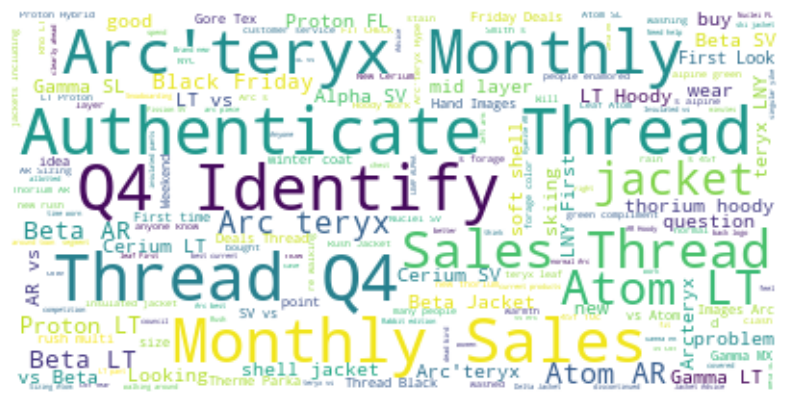

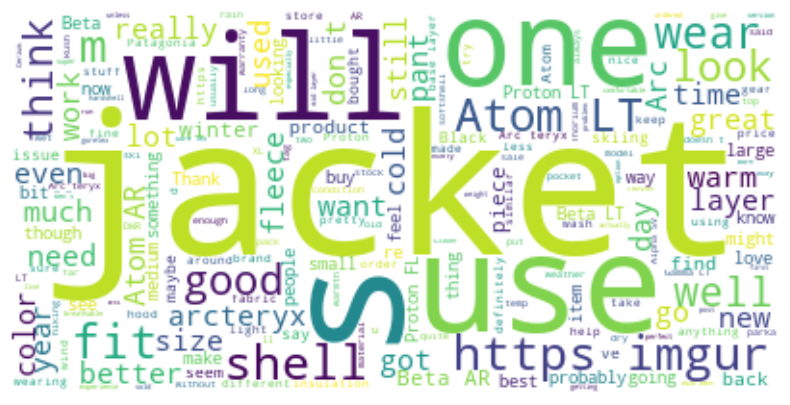

In [7]:
# Generate WordCloud for Arcteryx
text = " ".join(i for i in arcteryx_df['title'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Generate WordCloud for Arcteryx
text = " ".join(i for i in arcteryx_df['body'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### North Face Analysis

The North Face shares similarities with Arcteryx in that it also hosts common discussions of dominant products like jackets, including specific products (e.g. Nuptse thermal midlayer) for which community members are enthusiastic. While not participating through official identification threads, there are frequent inquiries for identifying sought after, often vintage products. Image and language processing techniques may help the company to identify products for which consumers are interested, particularly as companies (e.g. MEC) have become fond of re-releasing signature historical products. It also appears an active topic of discussion among North Face community members is identifying counterfeit apparel, which may come from the fact it is an older brand more widely known and copied around the world. Further image processing and data analysis might help in targeting and addressing this topic.

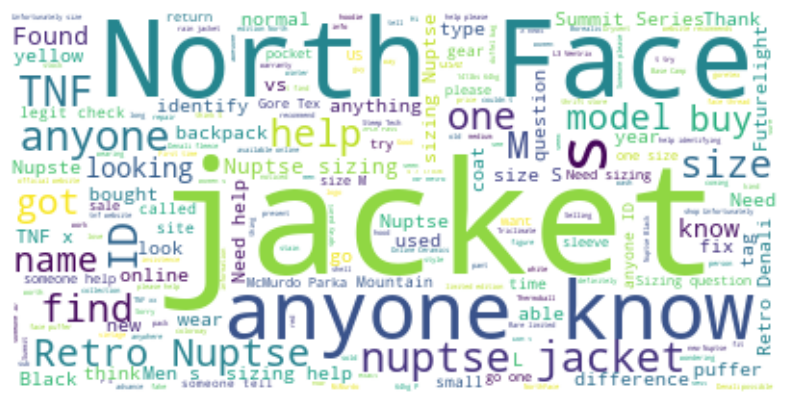

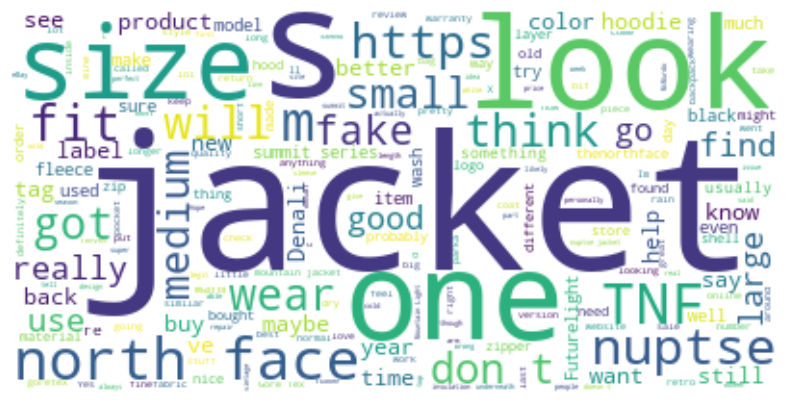

In [8]:
# Generate WordCloud for North Face
text = " ".join(i for i in northface_df['title'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Generate WordCloud for North Face
text = " ".join(i for i in northface_df['body'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Patagonia Analysis

Similar to North Face, Patagonia has particular products, especially jackets (e.g. Nano Puff thermal midlayer) which are very popular among its community members. Similar to other subreddits, Patagonia's community is  also a place where new or unfamiliar users also come to seek advice on products, in places like identifying which product might be most beneficial for a particular use case; how and where to procure a particular product that might be popular or difficult to find, etc. There are also common discussions among all three communities around fit, comfort and use of products. It appears Patagonia's content provides more midlayer content whereas Arcteryx has a stronger shell following.

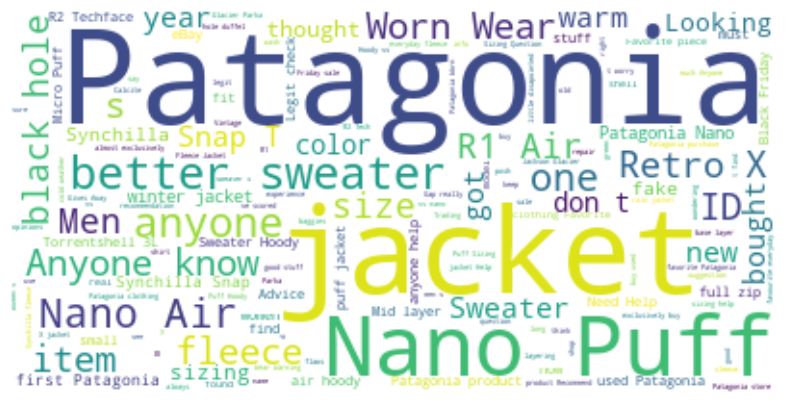

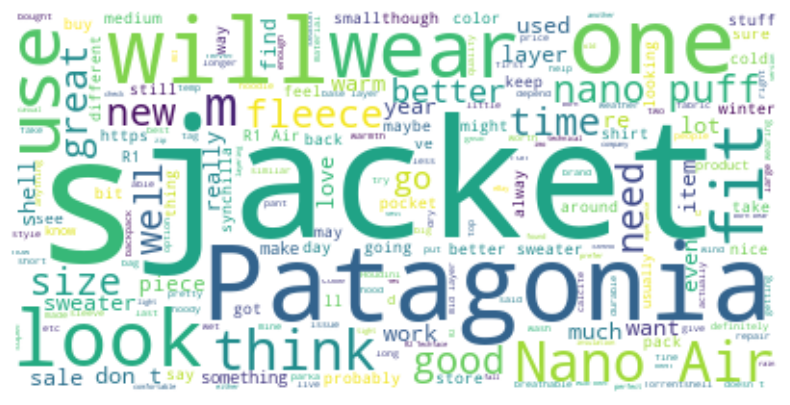

In [9]:
# Generate WordCloud for Patagonia
text = " ".join(i for i in patagonia_df['title'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Generate WordCloud for Patagonia
text = " ".join(i for i in patagonia_df['body'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Lululemon Analysis

Lululemon analysis differs from the aforementioned brands in a few ways, likely partly due to the fact it is not a mountaineering apparel company. Discussion tends to focus more actively around a wider variety of products and strong focus on dominant colour schemes (e.g. white/opal) and a wider variety of base and mid-layer type products for which Lululemon is well known like active wear. The discussion also appears to have a wider variety or stronger representation of emotive sentiment coverage such as community members loving a product, but also sharing thoughts and sentiments on a product.

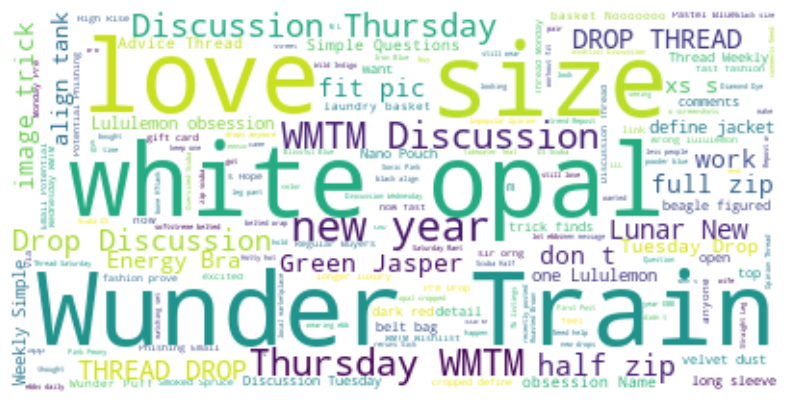

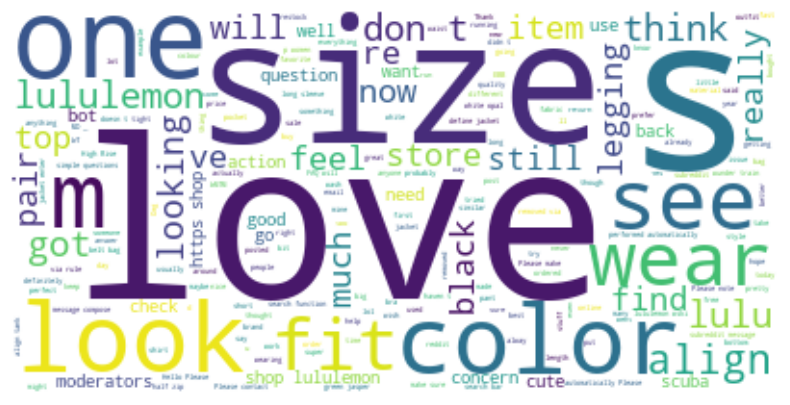

In [10]:
# Generate WordCloud for LuLuLemon
text = " ".join(i for i in lulu_df['title'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Generate WordCloud for LuLuLemon
text = " ".join(i for i in lulu_df['body'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Formal Data Cleaning

### Encode Categorical and Numeric Features, Drop Unused Features

In [11]:
# Import packages for scaling and encoding numeric and categorical features
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

# Categorical features for Ordinal Encoding
cat_cols = ['name',
            'url',
            'permalink',
            'post_id',
            'post_author',
            'link_flair_text',
            'over_18',
            'spoiler',
            'pinned',
            'locked',
            'comment_author',
            'comment_id',
            'author_flair',
            'submission',
            'stickied',
           'is_submitter',
            'parent_id',
            'subreddit'
            ]

# Numeric columns for MinMax Scaling
num_cols = ['post_score',
            'num_comments',
            'post_created_utc',
            'comment_score',
            'comment_created_utc',
            'upvote_ratio'
            ]

# Features to drop
drop_cols = ['title', 'selftext']

# MinMax Scaling
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(df[num_cols]))
scaled_data.columns = num_cols
df = df.drop(columns = num_cols)
df = pd.concat([df, scaled_data], axis = 1)

# Ordinal Encoding
encoder = OrdinalEncoder()
encoded_data = pd.DataFrame(encoder.fit_transform(df[cat_cols]))
encoded_data.columns = cat_cols
df = df.drop(columns = cat_cols)
df = pd.concat([df, encoded_data], axis = 1)

# Drop features
df = df.drop(columns = drop_cols)

## NLP Modelling

### Build NLP Model Pipeline

The following NLP model processes body text posted by an author to gauge sentiment expressed in the post. Further applications of this model are possible among individual comments; however, this post will focus primarily on the body of the text in the post since it conveys purpose driven communication from the original poster. The NLP pipeline uses a standard BagOfWords (BOW) vectorization, including use of a regex tokenizer to parcel out words, StopWords remover and assembler to prepare the text data for classification and further analysis.

In [12]:
# Pipeline is the package for generating pipelines under pyspark
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, VectorAssembler

# RegexTokenizer allows you to set patterns for breaking up text into tokens, StopWordsRemover removes non-essential words
# CountVectorizer converts the sentences in each text blob into numbers--similar to OneHotEncoding
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer


# Tokenize the text using simple RegexTokenizer
regexTokenizer = RegexTokenizer(inputCol = 'body', outputCol = 'words', pattern = '\\W', minTokenLength = 2)

# Remove standard stop words
stopwordsRemover = StopWordsRemover(inputCol = 'words', outputCol = 'filtered')

# Vectorize the sentence using simple BagOfWords Method
# minDF refers to the minimum length a token must be to count, or it's dropped
countVectors = CountVectorizer(inputCol = 'filtered', outputCol = 'bow', vocabSize = 10000, minDF = 5)

# Vector Assembler
assembler = VectorAssembler(inputCols = ['bow',
                                         'num_comments',
                                         'post_created_utc',
                                         'comment_score',
                                         'comment_created_utc',
                                         'name',
                                         'url',
                                         'permalink',
                                         'post_score',
                                         'post_id',
                                         'post_author',
                                         'link_flair_text',
                                         'over_18',
                                         'spoiler',
                                         'pinned',
                                         'locked',
                                         'comment_author',
                                         'comment_id',
                                         'author_flair',
                                         'submission',
                                         'stickied',
                                         'is_submitter',
                                         'parent_id'],
                                         outputCol = 'features'
                                         )

# Build preprocessing pipeline
bowPipeline = Pipeline(stages = [regexTokenizer, stopwordsRemover, countVectors, assembler])

### Call Pipeline to NLP Transform Training Data

The following code snippet calls the NLP pipeline for fitting to the dataframe.

In [13]:
# Read in spark packages
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert Pandas dataframe to Spark dataframe via Apache Arrow
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
sdf = spark.createDataFrame(df)

# Call BagOfWords (BOW) pipeline to transform data
pipelineFit = bowPipeline.fit(sdf)
sdf_trans = pipelineFit.transform(sdf)

23/01/27 14:56:15 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
/home/tom/anaconda3/envs/sparknlp/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:329: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
/home/tom/anaconda3/envs/sparknlp/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
23/01/27 14:56:18 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been depr

The following code snippet calls the TextBlob package on the body text to understand sentiment of the text. It then converts this sentiment into semi-supervised labels for sentiment, which can be fed to a classification model for predictive purposes.

/home/tom/anaconda3/envs/sparknlp/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
23/01/27 14:56:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/home/tom/anaconda3/envs/sparknlp/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:329: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution

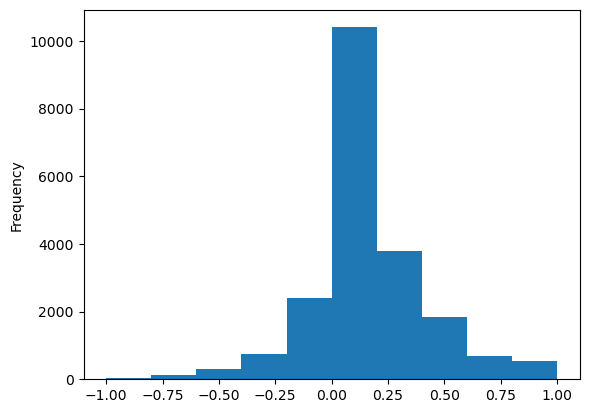

In [14]:
# Read in sentiment analysis packages
from textblob import TextBlob

# Define lower and upper dividing points for negative, neutral and positive
lower_div = -0.25
upper_div = 0.25

# Define sentiment function
def check_sentiment(x):
    return TextBlob(x).polarity

# Convert training data to Pandas dataframe to apply sentiment function
temp_df = sdf_trans.toPandas()
temp_df['sentiment'] = temp_df['body'].apply(lambda x: check_sentiment(x))

# Plot histogram to see general sentiment distribution for discussions
temp_df['sentiment'].plot.hist()

# Create new label column based on distribution of sentiment (1: Positive, 0.5: Neutral, 0: Negative)
conditions = [(temp_df['sentiment'] >= upper_div), ((temp_df['sentiment'] < upper_div) & (temp_df['sentiment'] > lower_div)), (temp_df['sentiment'] <= lower_div)]
values = ['positive', 'neutral', 'negative']
temp_df['label'] = np.select(conditions, values)

# Ordinal Encoding
label_encoder = OrdinalEncoder()
encoded_label = label_encoder.fit_transform(temp_df[['label']])
encoded_label = pd.DataFrame(encoded_label)
encoded_label = encoded_label.rename(columns = {0: 'label'})
temp_df = temp_df.drop(columns = 'label')
temp_df = pd.concat([temp_df, encoded_label], axis = 1)

# Convert pandas dataframe to spark for modelling
sdf_trans = spark.createDataFrame(temp_df)

### Data Train/Test Split

In [15]:
# Split data into train/test and set seed for reproducibility
(trainingData, testingData) = sdf_trans.randomSplit([0.7, 0.3], seed = 1)

# Print out Training and Testing dataset row counts
print('Training Dataset Count: ' + str(trainingData.count()))
print('Testing Dataset Count: '  + str(testingData.count()))

23/01/27 14:56:28 WARN TaskSetManager: Stage 5 contains a task of very large size (1397 KiB). The maximum recommended task size is 1000 KiB.
23/01/27 14:56:29 WARN TaskSetManager: Stage 8 contains a task of very large size (1397 KiB). The maximum recommended task size is 1000 KiB.


Training Dataset Count: 14477
Testing Dataset Count: 6338


### NLP Topic Modelling

Topic modelling provides relational analysis for text in your data, in this case, it analyzes Reddit posts within each community and seeks to group together words which are more related to each other than to other more distantly related text. The primary packages used in this model are NLTK for stripping out words and processing them (e.g. to remove stopwords like 'the) followed by use of SKLearn's Latent Dirichlet Allocation (LDA) which is an industry standard topic modelling approach.

In [16]:
# Import NLTK NLP packages
import nltk
nltk.download('all')

# create a list of Arcteryx text
arc_text = list(arcteryx_df['body'])
type(arc_text), len(arc_text)

# create a list of North Face text
nf_text = list(northface_df['body'])
type(nf_text), len(nf_text)

# create a list of Patagonia text
patagonia_text = list(patagonia_df['body'])
type(patagonia_text), len(patagonia_text)

# create a list of Lululemon text
lulu_text = list(lulu_df['body'])
type(lulu_text), len(lulu_text)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/tom/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /home/tom/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/tom/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/tom/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/tom/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /home/tom/nltk_data...
[nltk_data]    |   Package bc

(list, 8246)

The following pipeline creates the lists for holding words aggregated from Reddit posts and loops over each community's text to clean and append the content for futher processing.

In [17]:
# Import NLP processing packages
import re
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

arc_corpus = []
nf_corpus = []
patagonia_corpus = []
lulu_corpus = []

for i in range(len(arc_text)):
    r1 = re.sub('[^a-zA-Z]', ' ', arc_text[i])
    r1 = r1.lower()
    r1 = r1.split()
    r1 = [word for word in r1 if word not in stopwords.words('english')]
    r1 = [lemmatizer.lemmatize(word) for word in r1]
    r1 = ' '.join(r1)
    arc_corpus.append(r1)

for i in range(len(nf_text)):
    r2 = re.sub('[^a-zA-Z]', ' ', nf_text[i])
    r2 = r2.lower()
    r2 = r2.split()
    r2 = [word for word in r2 if word not in stopwords.words('english')]
    r2 = [lemmatizer.lemmatize(word) for word in r2]
    r2 = ' '.join(r2)
    nf_corpus.append(r2)

for i in range(len(patagonia_text)):
    r3 = re.sub('[^a-zA-Z]', ' ', patagonia_text[i])
    r3 = r3.lower()
    r3 = r3.split()
    r3 = [word for word in r3 if word not in stopwords.words('english')]
    r3 = [lemmatizer.lemmatize(word) for word in r3]
    r3 = ' '.join(r3)
    patagonia_corpus.append(r3)

for i in range(len(lulu_text)):
    r4 = re.sub('[^a-zA-Z]', ' ', lulu_text[i])
    r4 = r4.lower()
    r4 = r4.split()
    r4 = [word for word in r4 if word not in stopwords.words('english')]
    r4 = [lemmatizer.lemmatize(word) for word in r4]
    r4 = ' '.join(r4)
    lulu_corpus.append(r4)

The following packages transform the text into machine readable numeric content, while also removing english stopwords and ensuring each word occurs at least 5 times).

In [18]:
# Vectorizer for Arcteryx
from sklearn.feature_extraction.text import CountVectorizer

arc_cv = CountVectorizer(stop_words = 'english', min_df = 5)
arc_doc = arc_cv.fit_transform(arc_corpus)

# Vectorizer for North Face
from sklearn.feature_extraction.text import CountVectorizer
nf_cv = CountVectorizer(stop_words = 'english', min_df = 5)
nf_doc = nf_cv.fit_transform(nf_corpus)

# Vectorizer for Patagonia
from sklearn.feature_extraction.text import CountVectorizer
patagonia_cv = CountVectorizer(stop_words = 'english', min_df = 5)
patagonia_doc = patagonia_cv.fit_transform(patagonia_corpus)

# Vectorizer for Lululemon
from sklearn.feature_extraction.text import CountVectorizer
lulu_cv = CountVectorizer(stop_words = 'english', min_df = 5)
lulu_doc = lulu_cv.fit_transform(lulu_corpus)

The following LDA models process the numeric data from the previous step and seek to allocate the most related words into three groups, a number set by the modeller. This model has experimented with content between 2 and 4 categories and found greater numbers result in higher repetition of words between groups and some bleeding in meaning between them. 3 groups provides a suitable balance between diversity and simplicity of understanding; however, where it appeared weak association was identified for a specific subreddit, category count was adjusted to maximize interpretability and meaning.

In [19]:
# Topic model with 10 topics
from sklearn.decomposition import LatentDirichletAllocation

arc_lda = LatentDirichletAllocation(n_components = 3, random_state = 1)
arc_lda.fit(arc_doc)

nf_lda = LatentDirichletAllocation(n_components = 2, random_state = 1)
nf_lda.fit(nf_doc)

patagonia_lda = LatentDirichletAllocation(n_components = 3, random_state = 1)
patagonia_lda.fit(patagonia_doc)

lulu_lda = LatentDirichletAllocation(n_components = 2, random_state = 1)
lulu_lda.fit(lulu_doc)

LatentDirichletAllocation(n_components=2, random_state=1)

The following loops extract the related words into each respective grouping for the brand.

- **Arcteryx Analysis:** The main groupings appear to focus on comparing different products of both Arcteryx and competitors, as well as what colours a customer is buying and also website processing issues. Another grouping appears to focus on technical performance of products and the use of products across certain types of environments and sports.

- **North Face Analysis:** Groupings appear to prioritize utilitarian aspects of the products, including care instructions or efforts to search for or identify products among more experienced North Face consumers, and to seek guidance on their use cases.

- **Patagonia Analysis:** Topic groupings appear to focus more generally on discussions amongst community members who are interested in a particular product, in some cases discussing its use in particular environments/weather and others using negative sounding words (e.g. miss, complain) generally refer to missed opportunities to purchase an item, although there are references to complaints about product purchase experiences among consumers.

- **Lululemon Analysis:** One grouping appears to focus on customer experiences in purchasing, finding, caring for or experiencing damage to particular classes of products (e.g. grey clothes or a grey jacket). Another grouping applies to community members often purchasing, packing or finding deals on products.There are also commonalities among groups potentially associated with colours of products that could benefit from further analysis.

In [20]:
# see the most common words by topic
for index,topic in enumerate(arc_lda.components_):
    print(f'THE TOP ARCTERYX WORDS FOR TOPIC #{index}')
    print([arc_cv.get_feature_names()[i] for i in topic.argsort()[:10]])
    print('\n')

# see the most common words by topic
for index,topic in enumerate(nf_lda.components_):
    print(f'THE TOP NORTH FACE WORDS FOR TOPIC #{index}')
    print([nf_cv.get_feature_names()[i] for i in topic.argsort()[:10]])
    print('\n')

# see the most common words by topic
for index,topic in enumerate(patagonia_lda.components_):
    print(f'THE TOP PATAGONIA WORDS FOR TOPIC #{index}')
    print([patagonia_cv.get_feature_names()[i] for i in topic.argsort()[:10]])
    print('\n')

# see the most common words by topic
for index,topic in enumerate(lulu_lda.components_):
    print(f'THE TOP LULULEMON WORDS FOR TOPIC #{index}')
    print([lulu_cv.get_feature_names()[i] for i in topic.argsort()[:10]])
    print('\n')

THE TOP ARCTERYX WORDS FOR TOPIC #0
['phoenix', 'web', 'var', 'mkevt', 'mkcid', 'mkrid', 'ssspo', 'artemis', 'sssrc', 'widget']


THE TOP ARCTERYX WORDS FOR TOPIC #1
['pore', 'wick', 'crinkly', 'baselayers', 'activate', 'spin', 'pacnw', 'techface', 'miserable', 'variable']


THE TOP ARCTERYX WORDS FOR TOPIC #2
['transfer', 'bnwt', 'ibb', 'timelapse', 'conifer', 'techface', 'sz', 'tuesday', 'authentication', 'needing']


THE TOP NORTH FACE WORDS FOR TOPIC #0
['ecomm', 'aut', 'group', 'content', 'aw', 'gclsrc', 'bwe', 'sign', 'gclid', 'hybrid']


THE TOP NORTH FACE WORDS FOR TOPIC #1
['detergent', 'ball', 'tennis', 'puff', 'oversized', 'kg', 'tight', 'skinny', 'snug', 'puffy']


THE TOP PATAGONIA WORDS FOR TOPIC #0
['standing', 'granger', 'precip', 'retain', 'celsius', 'tumble', 'drizzle', 'freezing', 'stationary', 'errand']


THE TOP PATAGONIA WORDS FOR TOPIC #1
['initially', 'norm', 'ownership', 'searching', 'statement', 'earth', 'receipt', 'awful', 'oat', 'internationally']


THE TOP 

/home/tom/anaconda3/envs/sparknlp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Sentiment Classification Model

#### Logistic Regression (Predict Post Sentiment)

Logistic Regression with a simiple cross-validation process is used, based on experience for yielding the highest model performance (e.g. accuracy, etc) and to build in simple robustness and prevent overfitting to training data were the model to be put into production. A multiclass classification model is used since the model has characterized sentiment into three categories, negative, neutral and positive. Binary classification can be pursued by adjusting the semi-supervised model labels above.

In [21]:
# Read in packages
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Merge features into one column and prepare as X_train
final_train = trainingData.select('features', 'label')

# Instantiate Logistic Regression Classifier
lr = LogisticRegression(maxIter = 100, regParam = 0.3, elasticNetParam = 0)

# Space for inserting parameters
params = ParamGridBuilder().build()

# Set up Cross-Validation estimator
cv = CrossValidator(estimator = lr, estimatorParamMaps = params, evaluator = MulticlassClassificationEvaluator(), numFolds = 10)

# Fit model
lrModel = cv.fit(final_train)

23/01/27 14:57:22 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
23/01/27 14:57:22 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
23/01/27 14:57:22 WARN TaskSetManager: Stage 11 contains a task of very large size (1397 KiB). The maximum recommended task size is 1000 KiB.
23/01/27 14:57:23 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
23/01/27 14:57:23 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
23

The following code prints out the true positive rates for each classification (e.g. percentage of times it correctly picks the proper label). As seen below, the model is highly accurate with neutral classification (99%), fairly accurate with positive sentiment (61%) and faces challenges with negative sentiment (4%). This is likely due in part to the distribution of sentiment, which is shown overall to be highly neutral-to-positive in nature, likely given a high level of enthusiasm for brands in their specific communities. A larger sample of negative sentiment media data may help improve accuracy in this space.

In [22]:
# Create training summary from Crossvalidator run
trainingSummary = lrModel.bestModel.summary

# Print True Positive Rate for each label
trainingSummary.truePositiveRateByLabel

23/01/27 14:57:59 WARN TaskSetManager: Stage 987 contains a task of very large size (1397 KiB). The maximum recommended task size is 1000 KiB.
23/01/27 14:58:00 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
23/01/27 14:58:00 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
23/01/27 14:58:00 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
23/01/27 14:58:00 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
2

[0.037520391517128875, 0.9917716375457131, 0.6131840796019901]

#### Report Classification Model Performance on Training/Testing Data

The following are example dataframes with the actual label and predictions made by the model (0 = negative, 1 = neutral and 2 = positive) on both training and testing data.

In [23]:
final_train = trainingData[['features', 'label']]
prediction = lrModel.transform(final_train)
selected = prediction.select('features', 'probability', 'label', 'prediction').show()

+--------------------+--------------------+-----+----------+
|            features|         probability|label|prediction|
+--------------------+--------------------+-----+----------+
|(5440,[1,2,3,5,12...|[0.00632671648583...|  1.0|       1.0|
|(5440,[0,4,5,8,10...|[0.02261831042726...|  1.0|       1.0|
|(5440,[4,6,8,27,3...|[0.05507356153370...|  2.0|       1.0|
|(5440,[0,1,4,6,8,...|[0.02278196428569...|  2.0|       1.0|
|(5440,[2027,3832,...|[0.03829561320491...|  1.0|       1.0|
|(5440,[1,122,228,...|[0.03197344746329...|  1.0|       1.0|
|(5440,[0,1,6,10,1...|[0.00584363052506...|  1.0|       1.0|
|(5440,[1,5,6,18,2...|[0.02348075189885...|  1.0|       1.0|
|(5440,[0,1,4,8,27...|[0.02848246656271...|  1.0|       1.0|
|(5440,[12,14,15,6...|[0.02277915956239...|  1.0|       1.0|
|(5440,[0,7,13,24,...|[0.02764692131242...|  1.0|       1.0|
|(5440,[69,4957,54...|[0.03528457812698...|  1.0|       1.0|
|(5440,[76,215,231...|[0.05078710546272...|  1.0|       1.0|
|(5440,[0,2,6,10,1...|[0

23/01/27 14:58:00 WARN TaskSetManager: Stage 989 contains a task of very large size (1397 KiB). The maximum recommended task size is 1000 KiB.


In [24]:
# View results based on testing data
final_test = testingData[['features', 'label']]
prediction = lrModel.transform(final_test)
selected = prediction.select('features', 'probability', 'label', 'prediction').show()

23/01/27 14:58:00 WARN TaskSetManager: Stage 990 contains a task of very large size (1397 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-----+----------+
|            features|         probability|label|prediction|
+--------------------+--------------------+-----+----------+
|(5440,[4,8,40,82,...|[0.03465732087030...|  2.0|       2.0|
|(5440,[18,22,23,2...|[0.04634270910813...|  1.0|       1.0|
|(5440,[0,3,6,9,15...|[0.02496912025627...|  2.0|       1.0|
|(5440,[1,6,9,12,2...|[0.03397141660750...|  1.0|       1.0|
|(5440,[3,9,11,30,...|[0.00542214908321...|  1.0|       1.0|
|(5440,[13,24,69,1...|[0.03898385310706...|  2.0|       1.0|
|(5440,[1,38,42,43...|[0.05248251965250...|  2.0|       1.0|
|(5440,[4,6,8,33,5...|[0.11957572497685...|  1.0|       1.0|
|(5440,[1,4,5,8,11...|[0.01464985878929...|  1.0|       1.0|
|(5440,[1,4,5,8,11...|[0.02006018428437...|  1.0|       1.0|
|(5440,[4,6,8,11,3...|[0.04798046154913...|  1.0|       1.0|
|(5440,[1,4,8,24,2...|[0.02343737224174...|  1.0|       2.0|
|(5440,[4,8,10,55,...|[0.03458405814676...|  2.0|       1.0|
|(5440,[1,4,8,24,2...|[0

#### Feature Impacts on Sentiment Using PCA

The follwoing PCA model provides visual communication of which features endemic to the data collected from each subreddit can play a explanatory role in assessing the sentiment generated in each community.

/home/tom/anaconda3/envs/sparknlp/lib/python3.8/site-packages/pyspark/sql/pandas/conversion.py:87: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 1.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)
23/01/27 14:58:00 WARN TaskSetManager: Stage 991 contains a task of very large size (1397 KiB). The maximum recommended task size is 1000 KiB.


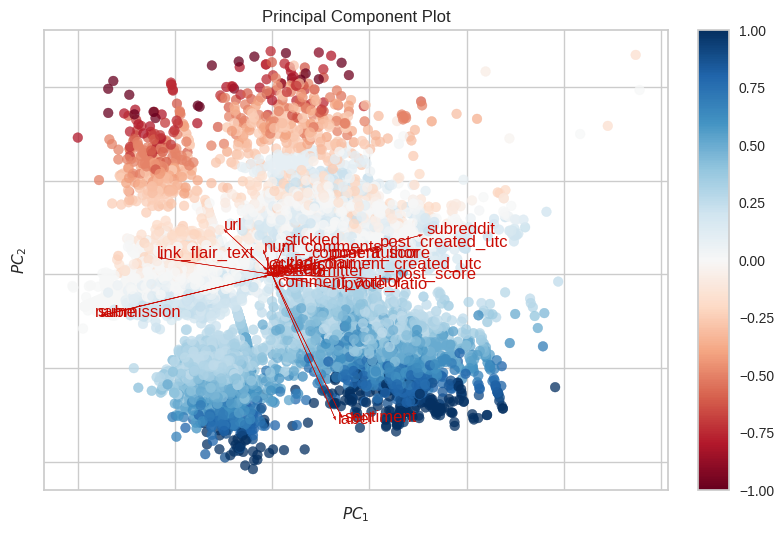

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [25]:
# Read in YellowBrick PCA package
from yellowbrick.features import PCA

# Make dataframes for features/labels
X_train = trainingData.toPandas()
X_train = X_train.drop(columns = ['body', 'words', 'filtered', 'bow', 'features', 'permalink', 'post_id', 'comment_id', 'parent_id'])
y_train = X_train['sentiment']

X, y = X_train, y_train

visualizer = PCA(scale=True, proj_features=True)
visualizer.fit_transform(X, y)
visualizer.show()